<a href="https://colab.research.google.com/github/Chizara69/rosee.github.io/blob/main/Diabetes_Prediction_Asses_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

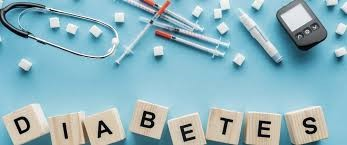

# Predicting Diabetes with Deep Learning : A Keras Model approach

Diabetes has become a prevalent health concern worldwide, affecting millions of lives and posing significant challenges to healthcare systems. Early detection and management of diabetes are crucial for preventing complications and improving quality of life. In this blog post, we'll explore how deep learning, specifically using the Keras framework, can be employed to predict the onset of diabetes

# Importing Libraraies

In [ ]:
# Import Libraries
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn import metrics

import os
seed = 100
os.environ['PYTHONHASHSEED']=str(seed)
# set all random seeds for the program (Python, NumPy, and TensorFlow)
keras.utils.set_random_seed(seed)



# Defining the problem and the dataset

We'll be working with a dataset containing eight features that are commonly associated with diabetes risk, see table below:

| Feature | Description | Data Type |
|---------|-------------|---------|
| A1      | Number of times pregnant | int64 |
| A2      | Plasma glucose concentration (mg/dL) after 2-hour oral glucose tolerance test | int64 |
| A3      | Diastolic blood pressure (mm Hg) | int64 |
| A4      | Triceps skin fold thickness (mm) | int64 |
| A5      | 2-Hour serum insulin (mu U/ml) | int64 |
| A6      | Body mass index (BMI) | float64 |
| A7      | Diabetes pedigree function | float64 |
| A8      | Age (years) | int64 |


The diagnosed labels are 0 for not positive and 1 for tested positive for Diabetes. The problem is to predict the class type of a patient given the above features from a set of test data.



# Loading and exploring the dataset

In [ ]:
# Load Dataset
df = pd.read_csv("train.csv")

Exploratory Data Analysis

In [ ]:
# Dimensions of training data
print(df.shape)

(668, 10)


In [ ]:
# 1st 5 rows of dataset
df.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8,class
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Checking for missing values
df.isnull().sum()

id       0
A1       0
A2       0
A3       0
A4       0
A5       0
A6       0
A7       0
A8       0
class    0
dtype: int64

Observations - There are no missing values, however there are many Zero entries in features A4 & A5.  To deal with this we will need to convert the Zero values into NaN values and then use the mean fill method to replace the NaN values.

In [ ]:
df.describe() # Lots of variation! We may need to consider standardising the data to bring to a more common range.

,id,A1,A2,A3,A4,A5,A6,A7,A8,class
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,334.500000,3.812874,120.405689,68.748503,20.567365,79.654192,31.860180,0.477329,33.091317,0.345808
std,192.979273,3.365672,32.291473,19.526392,16.020600,115.827750,7.827111,0.341398,11.711386,0.475988
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,167.750000,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.238750,24.000000,0.000000
50%,334.500000,3.000000,116.000000,72.000000,23.000000,36.500000,32.000000,0.377000,29.000000,0.000000
75%,501.250000,6.000000,140.000000,80.000000,32.000000,126.000000,36.500000,0.641250,40.000000,1.000000
max,668.000000,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: xlabel='class', ylabel='count'>

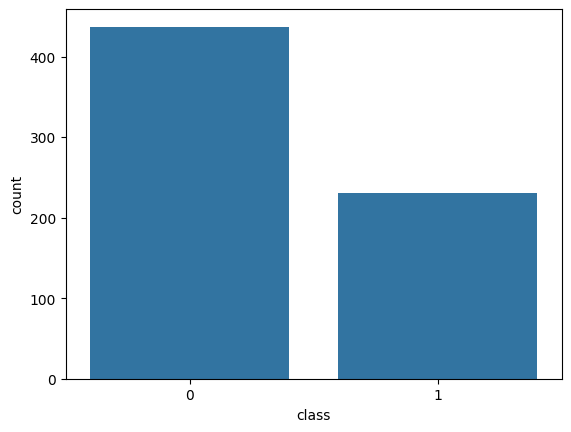

In [ ]:
# Lets take a look at the class distribution
sns.countplot(x=df["class"])

# Splitting labels and features

In [ ]:
# 1= Tested positive for diabetes 0= Negative
y = df["class"] # Target
print(y.value_counts())
y.head()

0    437
1    231
Name: class, dtype: int64


0    1
1    0
2    1
3    0
4    1
Name: class, dtype: int64

In [ ]:
# Drop unnecessary columns
x = df.drop(["id", "class"], axis=1)
print(x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      668 non-null    int64  
 1   A2      668 non-null    int64  
 2   A3      668 non-null    int64  
 3   A4      668 non-null    int64  
 4   A5      668 non-null    int64  
 5   A6      668 non-null    float64
 6   A7      668 non-null    float64
 7   A8      668 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 41.9 KB
None


In [ ]:
x.head() # Features

,A1,A2,A3,A4,A5,A6,A7,A8
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


#Modelling

We'll use a deep learning model implemented in Keras to  predict whether an individual is at risk of diabetes. The model will be trained on a portion of the dataset and evaluated on another portion to assess its accuracy and performance.




Splitting data into training and validation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=100)
print(f"Training set = {len(x_train)}")
print(f"Validation set = {len(x_val)}")

Training set = 467
Validation set = 201


In [ ]:
# Normalising the training data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

#Apply the same scaling to the val set
x_val = scaler.transform(x_val)

Model Architecture

Lets build the model using Keras using all the features in the data set to build a 2 hidden layer model.

In [ ]:
# We'll build a sequential model as we have singular inputs and outputs
model1 = keras.Sequential()
model1.add(layers.Dense(12, input_dim=8, activation="relu"))
model1.add(layers.Dense(8, activation="relu"))
model1.add(layers.Dense(1, activation="sigmoid"))
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile the keras model
model1.compile(loss="binary_crossentropy", optimizer = "adam", metrics=["accuracy"])

In [ ]:
# Train model
model1.fit(x_train, y_train, batch_size=50, epochs=60, validation_data=(x_val,y_val))

Epoch 1/60
10/10 [==============================] - 2s 44ms/step - loss: 0.7310 - accuracy: 0.6167 - val_loss: 0.6971 - val_accuracy: 0.6269
Epoch 2/60
10/10 [==============================] - 0s 12ms/step - loss: 0.7084 - accuracy: 0.6338 - val_loss: 0.6766 - val_accuracy: 0.6318
Epoch 3/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6896 - accuracy: 0.6381 - val_loss: 0.6590 - val_accuracy: 0.6468
Epoch 4/60
10/10 [==============================] - 0s 11ms/step - loss: 0.6732 - accuracy: 0.6488 - val_loss: 0.6432 - val_accuracy: 0.6617
Epoch 5/60
10/10 [==============================] - 0s 17ms/step - loss: 0.6577 - accuracy: 0.6531 - val_loss: 0.6293 - val_accuracy: 0.6716
Epoch 6/60
10/10 [==============================] - 0s 22ms/step - loss: 0.6442 - accuracy: 0.6552 - val_loss: 0.6168 - val_accuracy: 0.6816
Epoch 7/60
10/10 [==============================] - 0s 30ms/step - loss: 0.6314 - accuracy: 0.6638 - val_loss: 0.6046 - val_accuracy: 0.6915
Epoch 8/60
10

#Model Validation

In [ ]:
# Model prediction on validation data
y_pred1 = model1.predict(x_val)
print(y_pred1[:5])

7/7 [==============================] - 0s 4ms/step
[[0.09349283]
 [0.61207086]
 [0.11333659]
 [0.05374755]
 [0.66592425]]


In [ ]:
# Lets convert predictions into their class
y_pred1 = [1 if pred > 0.5 else 0 for pred in y_pred1]
print(y_pred1[:5])

[0, 1, 0, 0, 1]


In [ ]:
# Confirming Validation accuracy
accuracy = metrics.accuracy_score(y_val, y_pred1)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7711442786069652


In [ ]:
# clear session
keras.backend.clear_session()

# set random seed
keras.utils.set_random_seed(seed) # set all random seeds for the program (Python, NumPy, and TensorFlow)

#M2

Lets builds a model using all features but with more neurons

In [ ]:
# Splitting data into training and validation
x_train2, x_val2, y_train2, y_val2 = train_test_split(x, y, test_size=0.3, random_state=100)
print(f'training data set size: {len(x_train2)}')
print(f'validation data set size: {len(x_val2)}')


training data set size: 467
validation data set size: 201


In [ ]:
# Normalising the training data
scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train2)

#Apply the same scaling to the val set
x_val2 = scaler.transform(x_val2)

In [ ]:
# Defining Keras Model
model2 = keras.Sequential()
model2.add(layers.Dense(64, input_dim=8, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2689 (10.50 KB)
Trainable params: 2689 (10.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Putting together keras Model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train Model
model2.fit(x_train2, y_train2, batch_size=50, epochs=60, validation_data=(x_val2, y_val2))

Epoch 1/60
10/10 [==============================] - 3s 112ms/step - loss: 0.7008 - accuracy: 0.5075 - val_loss: 0.6359 - val_accuracy: 0.7811
Epoch 2/60
10/10 [==============================] - 0s 27ms/step - loss: 0.6228 - accuracy: 0.7409 - val_loss: 0.5870 - val_accuracy: 0.7811
Epoch 3/60
10/10 [==============================] - 0s 46ms/step - loss: 0.5775 - accuracy: 0.7516 - val_loss: 0.5512 - val_accuracy: 0.7811
Epoch 4/60
10/10 [==============================] - 0s 35ms/step - loss: 0.5480 - accuracy: 0.7559 - val_loss: 0.5204 - val_accuracy: 0.7811
Epoch 5/60
10/10 [==============================] - 0s 42ms/step - loss: 0.5241 - accuracy: 0.7602 - val_loss: 0.4966 - val_accuracy: 0.7761
Epoch 6/60
10/10 [==============================] - 0s 37ms/step - loss: 0.5064 - accuracy: 0.7559 - val_loss: 0.4774 - val_accuracy: 0.7910
Epoch 7/60
10/10 [==============================] - 0s 19ms/step - loss: 0.4919 - accuracy: 0.7666 - val_loss: 0.4656 - val_accuracy: 0.7910
Epoch 8/60
1

In [ ]:
# clear session
keras.backend.clear_session()

# set random seed
keras.utils.set_random_seed(seed) # set all random seeds for the program (Python, NumPy, and TensorFlow)

M2 is showing that the Model is possibly over fitting.
Lets include early stopping and optimise the accuracy during training.

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) # setting monitoring optimisation to 3

In [ ]:
#Defining keras model
model2_1 = keras.Sequential()
model2_1.add(layers.Dense(64, input_dim=8, activation='relu'))
model2_1.add(layers.Dense(32, activation='relu'))
model2_1.add(layers.Dense(1, activation='sigmoid'))

model2_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2689 (10.50 KB)
Trainable params: 2689 (10.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Complile keras model
model2_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training model with early stopping
model2_1.fit(x_train2, y_train2, batch_size=50, epochs=60, validation_data=(x_val2, y_val2), callbacks=[callback])

Epoch 1/60
10/10 [==============================] - 1s 25ms/step - loss: 0.7008 - accuracy: 0.5075 - val_loss: 0.6359 - val_accuracy: 0.7811
Epoch 2/60
10/10 [==============================] - 0s 9ms/step - loss: 0.6228 - accuracy: 0.7409 - val_loss: 0.5870 - val_accuracy: 0.7811
Epoch 3/60
10/10 [==============================] - 0s 6ms/step - loss: 0.5775 - accuracy: 0.7516 - val_loss: 0.5512 - val_accuracy: 0.7811
Epoch 4/60
10/10 [==============================] - 0s 6ms/step - loss: 0.5480 - accuracy: 0.7559 - val_loss: 0.5204 - val_accuracy: 0.7811


# M2_1 Model Validation

In [ ]:
# Model prediction on validation data
y_pred2 = model2_1.predict(x_val2)
print(y_pred2[:5])

7/7 [==============================] - 0s 2ms/step
[[0.29517657]
 [0.379763  ]
 [0.2674893 ]
 [0.3564651 ]
 [0.5924937 ]]


In [ ]:
# Lets convert predictions into their class
y_pred2 = [1 if pred > 0.5 else 0 for pred in y_pred2]
print(y_pred2[:5])

[0, 0, 0, 0, 1]


In [ ]:
# Confirming validation accuracy
accuracy = metrics.accuracy_score(y_val2, y_pred2)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7810945273631841


# Test Predictions
Using MD2_1 lets predict using the test data

In [ ]:
# Loading data
df_test = pd.read_csv("test.csv")

Some basic EDA on test data


In [ ]:
print(df_test.shape)
df_test.head()

(100, 9)


,id,A1,A2,A3,A4,A5,A6,A7,A8
0,1,6,98,58,33,190,34.0,0.430,43
1,2,9,154,78,30,100,30.9,0.164,45
2,3,6,165,68,26,168,33.6,0.631,49
3,4,1,99,58,10,0,25.4,0.551,21
4,5,10,68,106,23,49,35.5,0.285,47


In [ ]:
x_test = df_test

In [ ]:
print(x_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      100 non-null    int64  
 1   A1      100 non-null    int64  
 2   A2      100 non-null    int64  
 3   A3      100 non-null    int64  
 4   A4      100 non-null    int64  
 5   A5      100 non-null    int64  
 6   A6      100 non-null    float64
 7   A7      100 non-null    float64
 8   A8      100 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 7.2 KB
None


In [ ]:
x_test = df_test.drop(columns=['id'])

Lets prepare the test data as we did with the training data

In [ ]:
# Normalising the test data
x_test = scaler.fit_transform(x_test)

Apply Model2_1 to test data

In [ ]:
predictions = model2_1.predict(x_test)
print(predictions)

4/4 [==============================] - 0s 3ms/step
[[0.3997867 ]
 [0.5509733 ]
 [0.68917406]
 [0.23992953]
 [0.16422425]
 [0.557912  ]
 [0.23007686]
 [0.6278373 ]
 [0.40819943]
 [0.16776595]
 [0.27956924]
 [0.2666318 ]
 [0.14024192]
 [0.5487704 ]
 [0.23974133]
 [0.352765  ]
 [0.21751367]
 [0.47629547]
 [0.27074665]
 [0.22590728]
 [0.4315991 ]
 [0.5388668 ]
 [0.32808122]
 [0.4979088 ]
 [0.44362003]
 [0.5423312 ]
 [0.1566448 ]
 [0.46035814]
 [0.516197  ]
 [0.14049813]
 [0.47519615]
 [0.5132722 ]
 [0.4285409 ]
 [0.4318417 ]
 [0.6691714 ]
 [0.38245684]
 [0.2769639 ]
 [0.17271332]
 [0.16982906]
 [0.30180758]
 [0.52105117]
 [0.32725966]
 [0.3852919 ]
 [0.4137922 ]
 [0.56518584]
 [0.30365488]
 [0.17378746]
 [0.74411017]
 [0.66057736]
 [0.29355893]
 [0.32226673]
 [0.29121217]
 [0.2002523 ]
 [0.3112655 ]
 [0.47790378]
 [0.3926305 ]
 [0.1915832 ]
 [0.31055644]
 [0.38283083]
 [0.38181618]
 [0.35594505]
 [0.16368124]
 [0.4105565 ]
 [0.27370358]
 [0.6471789 ]
 [0.31210524]
 [0.23966113]
 [0.2428049

In [ ]:
#Converting test predictions into their class
predictions = [1 if pred > 0.5 else 0 for pred in predictions]
print(predictions)

[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
df_test['prediction'] = predictions

In [ ]:
df_test.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8,prediction
0,1,6,98,58,33,190,34.0,0.430,43,0
1,2,9,154,78,30,100,30.9,0.164,45,1
2,3,6,165,68,26,168,33.6,0.631,49,1
3,4,1,99,58,10,0,25.4,0.551,21,0
4,5,10,68,106,23,49,35.5,0.285,47,0


In [ ]:
df_test = df_test[['id', 'prediction']]

In [ ]:
df_test.head()

,id,prediction
0,1,0
1,2,1
2,3,1
3,4,0
4,5,0


In [ ]:
import json

data = []

for index, row in df_test.iterrows():

    data.append({'id': int(row['id']), 'prediction': int(row['prediction'])})

print(data[:5])

submission_file_path = 'submission.json'
with open(submission_file_path, 'w') as fp:

    for i in data:
        fp.write(json.dumps(i) + '\n')

[{'id': 1, 'prediction': 0}, {'id': 2, 'prediction': 1}, {'id': 3, 'prediction': 1}, {'id': 4, 'prediction': 0}, {'id': 5, 'prediction': 0}]


# Summary

In this blog post, we demonstrated how deep learning, specifically leveraging the Keras framework, can be utilized to predict diabetes risk based on various risk factors. By analyzing a dataset containing information such as pregnancy history, glucose levels, blood pressure, and more, we were able to develop a predictive model. Early detection of diabetes through such models holds immense potential for improving healthcare outcomes and quality of life for individuals at risk. Further research and refinement of these models can lead to more accurate predictions in diabetes management.